In [1]:
!pip -q install imbalanced-learn shap xgboost


In [2]:
from google.colab import files
import io, pandas as pd

# Upload the CSV file you just downloaded
uploaded = files.upload()

# Load into DataFrame
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print("Dataset loaded:", filename)
print(df.shape)
df.head()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
Dataset loaded: WA_Fn-UseC_-Telco-Customer-Churn.csv
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()
print("\nMissing values per column:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# check if any missing appeared after conversion
print("Missing after conversion:", df['TotalCharges'].isna().sum())

# drop rows where TotalCharges is missing
df = df.dropna(subset=['TotalCharges'])

print("New shape:", df.shape)
df.info()


Missing after conversion: 11
New shape: (7032, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 

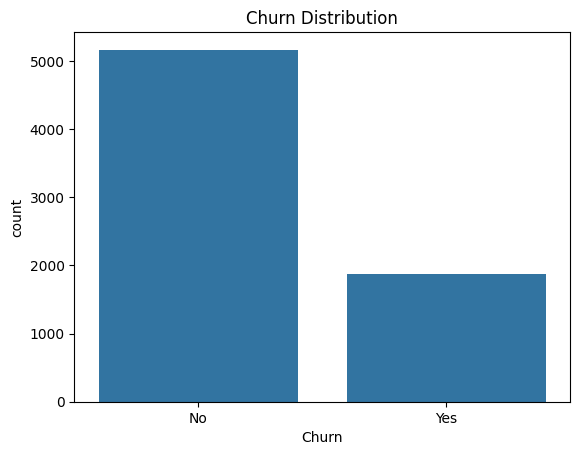

Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# countplot
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# percentages
print(df['Churn'].value_counts(normalize=True) * 100)


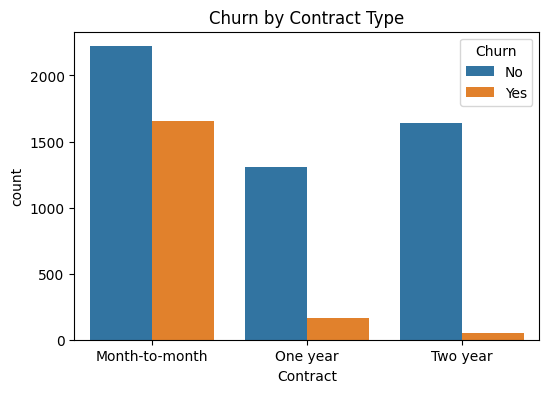

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.show()


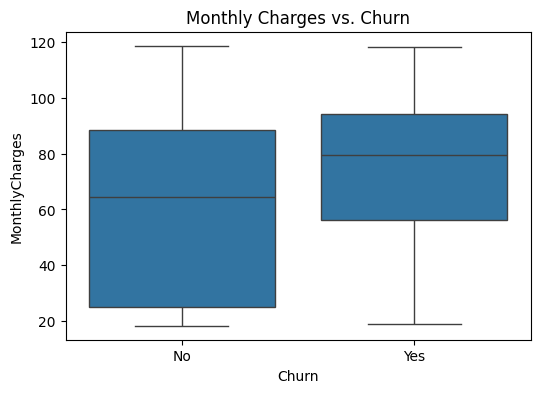

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs. Churn")
plt.show()


In [8]:

df = df.drop('customerID', axis=1)


In [9]:
from sklearn.preprocessing import LabelEncoder

# make a copy
df_model = df.copy()

# encode target
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})

# label encode binary columns, one-hot encode the rest
le = LabelEncoder()
for col in df_model.columns:
    if df_model[col].dtype == 'object':
        if df_model[col].nunique() == 2:
            df_model[col] = le.fit_transform(df_model[col])
        else:
            df_model = pd.get_dummies(df_model, columns=[col])

print("Final shape:", df_model.shape)
df_model.head()


Final shape: (7032, 41)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


In [10]:
from sklearn.model_selection import train_test_split

X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (5625, 40)  Test size: (1407, 40)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# train
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

# evaluate
print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407


Confusion Matrix:
 [[916 117]
 [159 215]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Confusion Matrix:
 [[927 106]
 [192 182]]


In [13]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # handle imbalance
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Report:\n")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Report:

              precision    recall  f1-score   support

           0       0.87      0.77      0.81      1033
           1       0.51      0.67      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407


Confusion Matrix:
 [[794 239]
 [123 251]]


In [16]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Re-train with a clear variable name
xgb_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
)
xgb_model.fit(X_train, y_train)

# ----- IMPORTANCES -----
# Logistic Regression (abs coefficients)
coef_importance = pd.Series(
    np.abs(log_reg.coef_[0]),
    index=X_train.columns
).sort_values(ascending=False).head(10)
print("Top 10 features (Logistic Regression):")
print(coef_importance)

# Random Forest
rf_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(10)
print("\nTop 10 features (Random Forest):")
print(rf_importance)

# XGBoost — use the trained model's attribute
xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(10)
print("\nTop 10 features (XGBoost):")
print(xgb_importance)


Top 10 features (Logistic Regression):
Contract_Two year                 0.732157
Contract_Month-to-month           0.660095
InternetService_DSL               0.411919
InternetService_Fiber optic       0.400839
PaperlessBilling                  0.292405
MultipleLines_No                  0.272144
PhoneService                      0.234538
Dependents                        0.226522
OnlineSecurity_Yes                0.224989
PaymentMethod_Electronic check    0.221878
dtype: float64

Top 10 features (Random Forest):
TotalCharges                      0.150246
tenure                            0.135057
MonthlyCharges                    0.131197
Contract_Month-to-month           0.088333
Contract_Two year                 0.036198
TechSupport_No                    0.033688
OnlineSecurity_No                 0.029934
PaymentMethod_Electronic check    0.027404
InternetService_Fiber optic       0.026793
gender                            0.024778
dtype: float64

Top 10 features (XGBoost):
Contract_

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

proba = xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.40
y_pred_thresh = (proba >= threshold).astype(int)

print(f"XGBoost @ threshold={threshold}")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))


XGBoost @ threshold=0.4
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1033
           1       0.50      0.72      0.59       374

    accuracy                           0.73      1407
   macro avg       0.69      0.73      0.69      1407
weighted avg       0.78      0.73      0.74      1407

Confusion Matrix:
 [[757 276]
 [103 271]]


In [18]:
top_feats = pd.DataFrame({
    "feature": xgb_importance.index,
    "importance": xgb_importance.values
})
top_feats.to_csv("top_features_xgb.csv", index=False)


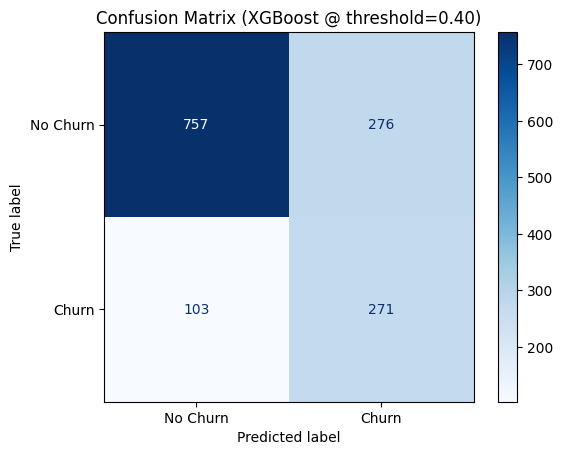

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_thresh,
    display_labels=["No Churn", "Churn"],
    cmap="Blues"
)
plt.title("Confusion Matrix (XGBoost @ threshold=0.40)")
plt.savefig("confusion_matrix_xgb.png", dpi=150)
plt.show()
